<a href="https://colab.research.google.com/github/oodlbee/drug_prediction/blob/bob2708_branch/drug_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 26.6 MB/s eta 0:00:00


In [83]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [292]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [34]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка

## Уже обработанное

In [293]:
full = pd.read_csv("https://raw.githubusercontent.com/oodlbee/drug_prediction/master/processed_df.csv")
full.head(1)

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,#stars,...,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2.0,...,0.0,0.0,35.245,2.0,0.0,0.0,0.0,0.0,0.0,14.0


In [294]:
full.drop(["Title", "SMILES"], axis=1, inplace=True)
X = full.iloc[:, 3:]
y = full.iloc[:, :3]
y_si = y["SI"]
y_ic = y["IC50, mmg/ml"]
y_cc = y["CC50-MDCK, mmg/ml"]
X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

## Первый лист 1400

In [287]:
df_1400 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx')
df_1400.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0


In [215]:
df_1400.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures
count,1468.000000,1468.000000,1.444000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000
mean,50.277063,186.491530,2.217641e+04,384.739636,3.831744,1.333787,81.273215,364.909216
std,92.184768,1009.454293,4.726006e+05,153.164268,2.860473,1.803663,54.078778,210.154325
min,0.000010,0.031928,0.000000e+00,110.157000,0.000000,0.000000,0.000000,1.000000
25%,2.500000,30.375000,1.885549e+00,283.049250,2.000000,0.000000,39.440000,183.500000
50%,10.100000,90.400000,5.600000e+00,349.371000,3.000000,1.000000,71.840000,365.000000
75%,49.450000,300.000000,2.832642e+01,446.508000,5.000000,2.000000,106.160000,546.500000
max,1000.000000,37646.000000,1.596170e+07,1159.380000,19.000000,11.000000,319.510000,728.000000


In [216]:
df_1400_easy = df_1400.drop(["Title", "Pictures", "SMILES"], axis=1)
df_1400_easy['SI'] = df_1400_easy['CC50-MDCK, mmg/ml']/df_1400_easy['IC50, mmg/ml']
df_1400_easy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   IC50, mmg/ml             1468 non-null   float64
 1   CC50-MDCK, mmg/ml        1468 non-null   float64
 2   SI                       1468 non-null   float64
 3   Molecular weight         1468 non-null   float64
 4   Hydrogen bond acceptors  1468 non-null   int64  
 5   Hydrogen bond donors     1468 non-null   int64  
 6   Polar SA                 1468 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 80.4 KB


In [217]:
X = df_1400_easy.iloc[:, 3:]
y = df_1400_easy.iloc[:, :3]
X

,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA
0,195.307,2,1,32.59
1,195.307,2,1,32.59
2,250.431,1,0,15.60
3,222.377,1,0,15.60
4,239.361,2,0,29.54
...,...,...,...,...
1463,238.330,3,0,39.44
1464,427.417,2,1,124.74
1465,427.417,2,1,124.74
1466,320.304,1,0,89.49


In [218]:
# Варианты целевой колонки
y_si = y["SI"]
y_ic = y["IC50, mmg/ml"]
y_cc = y["CC50-MDCK, mmg/ml"]

In [219]:
# Не забываем заменить агрумент 'y' при выборе другого целевого столбца
X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

## Второй лист 1400

In [259]:
df_1400_big = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx', 1)
df_1400_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   molecule                    1468 non-null   object 
 1   Pictures                    727 non-null    float64
 2   SMILES                      1468 non-null   object 
 3   IC50, mmg/ml                1468 non-null   float64
 4   CC50-MDCK, mmg/ml           1468 non-null   float64
 5   SI                          1444 non-null   float64
 6   #stars                      1417 non-null   float64
 7   #amine                      1417 non-null   float64
 8   #amidine                    1417 non-null   float64
 9   #acid                       1417 non-null   float64
 10  #amide                      1417 non-null   float64
 11  #rotor                      1417 non-null   float64
 12  #rtvFG                      1417 non-null   float64
 13  CNS                         1417 

In [260]:
df_1400_big = df_1400_big.drop(['molecule', 'Pictures', 'SMILES', 'Unnamed: 55', 'Unnamed: 56'], axis=1)
df_1400_big.dropna(inplace=True)

In [261]:
X = df_1400_big.iloc[:, 3:]
y = df_1400_big.iloc[:, :3]
y_si = y["SI"]
y_ic = y["IC50, mmg/ml"]
y_cc = y["CC50-MDCK, mmg/ml"]

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

# Запуск моделей

## Линейная регрессия

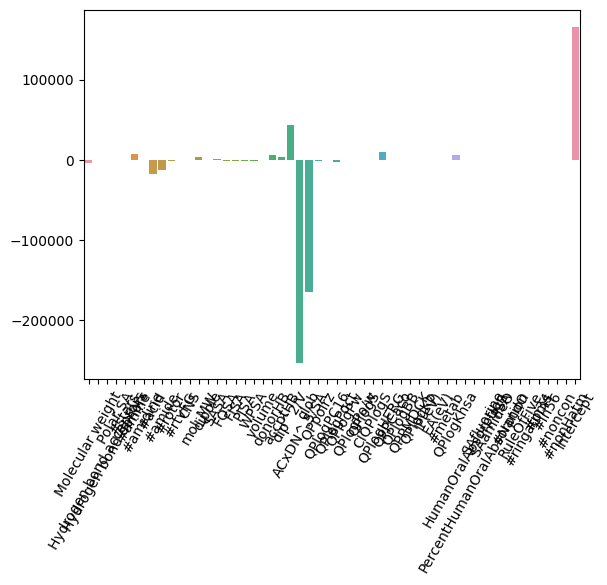

In [290]:
lr = LinearRegression().fit(X_train, y_train)
figure(figsize=(8, 6), dpi=80)
coefs = np.append(lr.coef_, lr.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(x=names, y=coefs)#, columns=X_train.columns)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

## SVR

In [221]:
svr = SVR().fit(X_train, y_train)

## Деревья (лес)

In [222]:
rf = RandomForestRegressor().fit(X_train, y_train)

## Деревья (Бустинг)

In [223]:
ada = AdaBoostRegressor().fit(X_train, y_train)
cat = CatBoostRegressor(verbose=False).fit(X_train, y_train)

# Оценка моделей

In [189]:
def calc_metrics(model, X_test=X_test, y_test=y_test, df=None):
    pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mae = median_absolute_error(y_test, pred)
    if df is not None:
        df.loc[str(model)] = [mae, r2]
    else:
        print(f"R-score: {r2}\nMAE: {mae}")

In [190]:
models = [lr, svr, rf, ada, cat]
metrics = pd.DataFrame(columns=('MAE', 'R2'))

In [191]:
for model in models:
    calc_metrics(model, df=metrics)

In [192]:
metrics

,MAE,R2
LinearRegression(),36.214498,0.220047
SVR(),9.794311,-0.158393
RandomForestRegressor(),19.897817,0.296495
AdaBoostRegressor(),39.614299,0.116823
<catboost.core.CatBoostRegressor object at 0x7d83b63ef8b0>,22.000924,0.209541


In [193]:
opa = pd.DataFrame({"Predicted": svr.predict(X_test), "True": y_test})
opa.describe()

,Predicted,True
count,349.000000,349.000000
mean,11.881337,53.553814
std,6.347405,100.785796
min,4.428265,0.000018
25%,6.093811,2.500000
50%,10.004368,10.100000
75%,16.940642,52.700000
max,27.316839,1000.000000


In [144]:
df_1400.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures
count,1468.000000,1468.000000,1.444000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000
mean,50.277063,186.491530,2.217641e+04,384.739636,3.831744,1.333787,81.273215,364.909216
std,92.184768,1009.454293,4.726006e+05,153.164268,2.860473,1.803663,54.078778,210.154325
min,0.000010,0.031928,0.000000e+00,110.157000,0.000000,0.000000,0.000000,1.000000
25%,2.500000,30.375000,1.885549e+00,283.049250,2.000000,0.000000,39.440000,183.500000
50%,10.100000,90.400000,5.600000e+00,349.371000,3.000000,1.000000,71.840000,365.000000
75%,49.450000,300.000000,2.832642e+01,446.508000,5.000000,2.000000,106.160000,546.500000
max,1000.000000,37646.000000,1.596170e+07,1159.380000,19.000000,11.000000,319.510000,728.000000


(78.17298725110437,
 array([ -0.11273714,   1.29365422, -10.65273132,   0.32943866]))